# Practice: gym interface and crossentropy method

_Reference:_ This notebook is based on Practical RL [week01](https://github.com/yandexdataschool/Practical_RL/tree/master/week01_intro)

In [1]:
import os
import sys


if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

Starting virtual X frame buffer: Xvfb.


## OpenAI Gym

We're gonna spend several next weeks learning algorithms that solve decision processes. We are then in need of some interesting decision problems to test our algorithms.

That's where OpenAI Gym comes into play. It's a Python library that wraps many classical decision problems including robot control, videogames and board games.

So here's how it works:

c:\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Observation space: Box(2,)
Action space: Discrete(3)


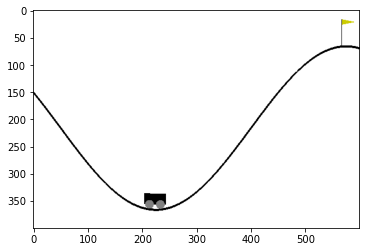

In [1]:
import gym
import matplotlib.pyplot as plt


env = gym.make("MountainCar-v0")
env.reset()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
plt.imshow(env.render("rgb_array"));

### Gym interface

The three main methods of an environment are
* `reset()`: reset environment to the initial state, and _return it_
* `render()`: show current environment state (a more colorful version)
* `step(a)`: commit action `a` and return `(new_state, reward, is_done, info)`
 * `new_state`: the new state right after committing the action `a`
 * `reward`: a number representing your reward for committing action `a`
 * `is_done`: True if the MDP has just finished, False if still in progress
 * `info`: some auxiliary stuff about what just happened. For now, ignore it.

In [6]:
state = env.reset()
print("initial state:", state)

initial state: [-0.5144028  0.       ]


In MountainCar, observation is just two numbers: car position and velocity.

Let's take action 2, which stands for "go right".

In [4]:
print("taking action 2 (right)")
new_state, reward, is_done, _ = env.step(2)

print("new state:", new_state)
print("reward:", reward)
print("is game over?:", is_done)

taking action 2 (right)
new state: [-0.5132647   0.00092947]
reward: -1.0
is game over?: False


As you can see, the car has moved to the right slightly (around 0.0005).

### Play with it

Below is the code that drives the car to the right. However, if you simply use the default policy, the car will not reach the flag at the far right due to gravity.

__Your task__ is to fix it. Find a strategy that reaches the flag. 

You are not required to build any sophisticated algorithms for now, and you definitely don't need to know any reinforcement learning for this. Feel free to hard-code :)

In [5]:
actions = {"left": 0, "stop": 1, "right": 2}


def policy(state, time_step):
    # Write the code for your policy here. You can use the current state
    # (a tuple of position and velocity), the current time step, or both,
    # if you want.
    position, velocity = state

    # This is an example policy. You can try running it, but it will not work.
    # Your goal is to fix that. You don't need anything sophisticated here,
    # and you can hard-code any policy that seems to work.

    if velocity < 0:
        return actions["left"]

    return actions["right"]

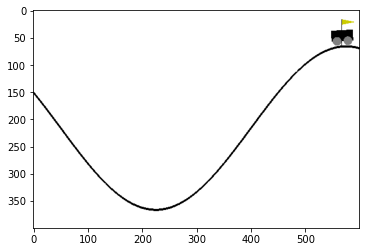

Well done!


In [7]:
from IPython.display import clear_output, display


state = env.reset()
time_limit = 250
for time_step in range(time_limit):
    # Choose action based on your policy.
    action = policy(state, time_step)

    # Pass the action to the environment.
    state, reward, done, _ = env.step(action)

    # We don't do anything with reward here because MountainCar is a very
    # simple environment, and reward is a constant -1 (meaning that your
    # goal is to end the episode as quickly as possible).

    # Draw game image on display.
    clear_output(wait=True)
    plt.imshow(env.render("rgb_array"))
    plt.show()

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

## Crossentropy method

Now that we know how does the `gym` work, let's try and solve a more complicated problem using the crossentropy method.

In [8]:
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



As `Taxi-v3` is a much more sophisticated environment, it presents us with more possible states and actions at our disposal.

In [9]:
n_states, n_actions = env.observation_space.n, env.action_space.n
print(f"n_states={n_states}, n_actions={n_actions}")

n_states=500, n_actions=6


That's definitely a lot. Way too much to hard-code as we did with previous problem. Let's use the crossentropy method on this one.

### Create stochastic policy

This time our policy should be a probability distribution.

```policy[s, a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.

In [10]:
import numpy as np


def initialize_policy(n_states, n_actions):
    # Create an array to store action probabilities
    policy = np.full([n_states, n_actions], 1 / n_actions)

    return policy

In [11]:
policy = initialize_policy(n_states, n_actions)
assert isinstance(policy, np.ndarray)
assert np.allclose(policy, 1 / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

### Play the game

Let's play the game just like before, however this time we will also record states, actions and rewards to use them in training loop.

In [12]:
def generate_session(env, policy, time_limit=10 ** 4):
    state = env.reset()
    states, actions = [], []
    total_reward = 0.0
    for _ in range(time_limit):
        # Choose action based on policy and take it.
        action = np.random.choice(n_actions, p=policy[state])
        new_state, reward, done, _ = env.step(action)

        # Record information we just got from the environment.
        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_state
        if done:
            break

    return states, actions, total_reward

In [13]:
states, actions, reward = generate_session(env, policy)
assert isinstance(states, list) and isinstance(actions, list)
assert len(states) == len(actions)
assert isinstance(reward, float)

Let's see the initial reward distribution for our "naive" policy.

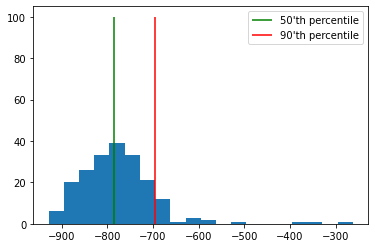

In [14]:
sample_rewards = [generate_session(env, policy, time_limit=1000)[2] for _ in range(200)]
plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color="green")
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color="red")
plt.legend();

### Crossentropy method step

In [15]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile.

    Compute minimum reward for session to be elite and choose elite states
    and actions based on this threshold.

    Note that states_batch and actions_batch are both 2d lists, i.e. lists
    containing lists of states and actions from each session in batch.
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    for session_states, session_reward in zip(states_batch, rewards_batch):
        # If session is not elite - skip it
        if session_reward < reward_threshold:
            continue

        elite_states.extend(session_states)

    elite_actions = []
    for session_actions, session_reward in zip(actions_batch, rewards_batch):
        # If session is not elite - skip it
        if session_reward < reward_threshold:
            continue

        elite_actions.extend(session_actions)

    return elite_states, elite_actions

In [16]:
states_batch = [
    [1, 2, 3],  # game1
    [4, 2, 0, 2],  # game2
    [3, 1],  # game3
]

actions_batch = [
    [0, 2, 4],  # game1
    [3, 2, 0, 1],  # game2
    [3, 3],  # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]
), "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]
), "Please make sure you use >=, not >. Also double-check how you compute percentile."

Exception ignored in: <function Viewer.__del__ at 0x000001A4D377F9D0>
Traceback (most recent call last):
  File "c:\Anaconda\lib\site-packages\gym\envs\classic_control\rendering.py", line 152, in __del__
  File "c:\Anaconda\lib\site-packages\gym\envs\classic_control\rendering.py", line 71, in close
  File "c:\Anaconda\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
  File "c:\Anaconda\lib\site-packages\pyglet\window\__init__.py", line 823, in close
  File "c:\Anaconda\lib\_weakrefset.py", line 114, in remove
KeyError: <weakref at 0x000001A4DCB1FBD0; to 'Win32Window' at 0x000001A4D3348640>


In [17]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites, return a new
    policy where each action probability is proportional to

        policy[s, a] ~ #[occurrences of s and a in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities.
    For states that you never visited, use a uniform distribution.
    """

    new_policy = np.zeros([n_states, n_actions])

    # Set probabilities for actions given elite states & actions.
    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1

    # Don't forget to set 1/n_actions for all actions in unvisited states.
    for state in np.where(np.sum(new_policy, axis=1) < 1):
        new_policy[state, :] = 1

    new_policy /= np.sum(new_policy, axis=1, keepdims=True)

    return new_policy

In [18]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]
new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy
).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(
    new_policy.sum(axis=-1), 1
), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 0.5],
    ]
)
assert np.allclose(new_policy[:4, :5], reference_answer)

### Training loop

Generate sessions, select N best and fit to those.

In [19]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)

    mean_rewards = [mean_reward for mean_reward, threshold in log]
    reward_thresholds = [threshold for mean_reward, threshold in log]
    plt.plot(mean_rewards, label="Mean rewards")
    plt.plot(reward_thresholds, label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        ymin=[0],
        ymax=[100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(wait=True)
    print(f"mean reward = {mean_reward:.3f}, threshold={threshold:.3f}")
    plt.show()

In [20]:
# reset policy
policy = initialize_policy(n_states, n_actions)

mean reward = -57.760, threshold=6.000


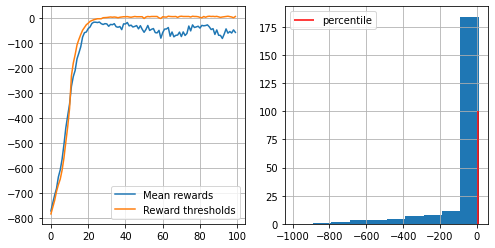

In [21]:
n_sessions = 250  # sample this many sessions
percentile = 50  # take this percent of session with highest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for _ in range(100):
    # Generate a list of n_sessions new sessions, select elites and compute
    # new policy based on them. After that update the existing policy wrt
    # learning rate.
    sessions = [generate_session(env, policy) for _ in range(n_sessions)]

    states_batch = [session_states for session_states, session_actions, session_reward in sessions]

    actions_batch = [session_actions for session_states, session_actions, session_reward in sessions]

    rewards_batch = [session_reward for session_states, session_actions, session_reward in sessions]

    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, rewards_batch, percentile
    )

    new_policy = get_new_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

### Analysing the results

You may have noticed that the taxi problem quickly converges from very little values to a near-optimal score and then descends back. This is caused (at least in part) by the innate randomness of the environment. Namely, the starting points of passenger/driver change from episode to episode.

In such case if crossentropy policy failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running several games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.

## Deeging deeper: approximate crossentropy with neural networks

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games.

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)

c:\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


state vector dim = 4
n_actions = 2


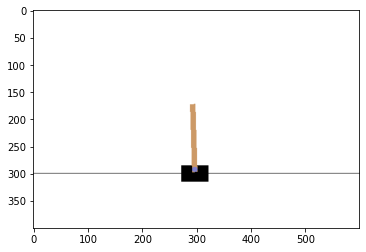

In [22]:
# .env is to remove auto-assigned time limit wrapper
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

print("state vector dim =", state_dim)
print("n_actions =", n_actions)
plt.imshow(env.render("rgb_array"));

Here, just like in a `MountainCar-v0`, we will be controlling a cart, which we can move right or left. However our goal here is different. In this environment we want to keep pole attached to the top of our cart from falling as long as possible.

### Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). Here's what you'll need:
* `agent.partial_fit(states, actions)` - make a single training pass over the data to increase the probability of provided `actions` in provided `states`
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape `[len(states), n_actions] `

In [23]:
from sklearn.neural_network import MLPClassifier


agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions));

Despite the apparent differences, you will find the training procedure for such agent to be very similar to the one we used in the previous part. We won't even need to rewrite most of our helper functions at all! However, one thing that has changed is the way we get actions' probabilities. So let's adapt our `generate_session` function to this new agent-based policy.

In [24]:
def generate_session(env, agent, time_limit=10 ** 4):
    state = env.reset()
    states, actions = [], []
    total_reward = 0.0
    for _ in range(time_limit):
        # Use agent to predict a vector of action probabilities for current
        # state and use the probabilities you predicted to pick an action.
        # Sample actions, don't just take the most likely one!
        action_probabilities = agent.predict_proba([state]).squeeze()
        action = np.random.choice(n_actions, p=action_probabilities)
        new_state, reward, done, _ = env.step(action)

        # Record information we just got from the environment.
        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_state
        if done:
            break

    return states, actions, total_reward

In [25]:
states, actions, reward = generate_session(env, agent, time_limit=5)
print("states:", np.stack(states))
print("actions:", actions)
print("reward:", reward)

states: [[ 0.04713376 -0.03835604  0.02126667  0.04921437]
 [ 0.04636664  0.15645461  0.02225096 -0.2366836 ]
 [ 0.04949574  0.35125172  0.01751729 -0.52226568]
 [ 0.05652077  0.54612278  0.00707198 -0.80937761]
 [ 0.06744323  0.74114712 -0.00911558 -1.09982766]]
actions: [1, 1, 1, 1, 0]
reward: 5.0


### Training loop

mean reward = 2613.890, threshold=3309.000


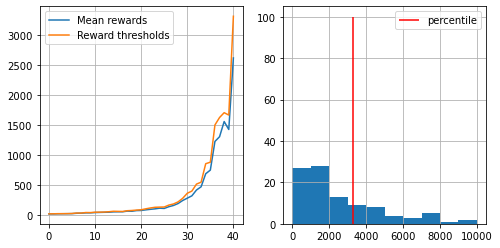

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

: 

In [26]:
n_sessions = 100
percentile = 70

log = []

for _ in range(100):
    # Generate new sessions, select elites and update our agent.
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]
    states_batch = [session_states for session_states, session_actions, session_reward in sessions]

    actions_batch = [session_actions for session_states, session_actions, session_reward in sessions]

    rewards_batch = [session_reward for session_states, session_actions, session_reward in sessions]

    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, rewards_batch, percentile
    )

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

### Analysing the results

Let's record a video of our agent playing.

In [26]:
import gym.wrappers


with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

In [27]:
from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([file for file in Path("videos").iterdir() if file.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

## Bonus area I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks

- __1.1__ (1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.

```<Describe what you did here.  Preferably with plot/report to support it.>```

## Bonus area II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

> Note: if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (bonus: 4++ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  * __Please list what you did in anytask submission form__

### Tips

* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [ ]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs


plt.imshow(visualize_mountain_car(env, agent))

### More bonus tasks

* __2.3 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v0"](https://github.com/openai/gym/wiki/Pendulum-v0).
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.